# LocalDescriptors: Steinhardt OPs
The `freud.environment` module analyzes the local environments of particles. The `freud.environment.LocalDescriptors` class is a useful tool for analyzing identifying crystal structures in a rotationally invariant manner using local particle environments. The primary purpose of this class is to compute spherical harmonics between neighboring particles in a way that orients particles correctly relative to their local environment, ensuring that global orientational shifts do not change the output.

In [1]:
import freud
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import util

## Computing Spherical Harmonics

To demonstrate the basic application of the class, let's compute the spherical harmonics between neighboring particles.
For simplicity, we consider points on a simple cubic lattice.

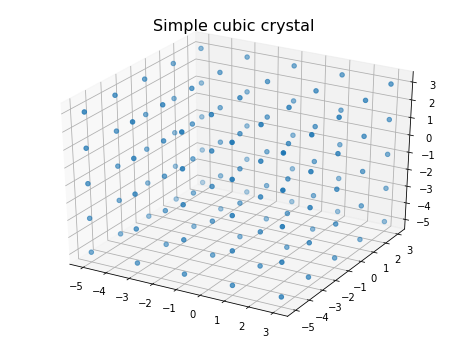

In [2]:
box, points = util.make_sc(5, 5, 5)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_title("Simple cubic crystal", fontsize=16);
plt.show()

Now, let's use the class to compute an array of spherical harmonics for the system.
The harmonics are computed for each bond, where a bond is defined by a pair of particles that are determined to lie within each others' nearest neighbor shells based on a standard neighbor list search.
The number of bonds and spherical harmonics to calculate is configurable.

In [3]:
num_neighbors = 6
l_max = 12
r_max = 2

# In order to be able to access information on which particles are bonded
# to which ones, we precompute the neighborlist
nn = freud.locality.NearestNeighbors(r_max, num_neighbors)
nn.compute(box, points)
nl = nn.nlist
ld = freud.environment.LocalDescriptors(num_neighbors, l_max, r_max)
ld.compute(box, num_neighbors, points, mode='global', nlist=nl);

## Accessing the Data

The resulting spherical harmonic array has a shape corresponding to the number of neighbors.
We can now extract the spherical harmonics corresponding to a particular $(l, m)$ pair using the ordering used by the LocalDescriptors class: increasing values of $l$, and for each $l$, the nonnegative $m$ values followed by the negative values.

In [4]:
sph_raw = np.mean(ld.sph, axis=0)
count = 0
sph = np.zeros((l_max+1, l_max+1), dtype=np.complex128)
for l in range(l_max+1):
    for m in range(l+1):
        sph[l, m] = sph_raw[count]
        count += 1
    for m in range(-l, 0):
        sph[l, m] = sph_raw[count]
        count += 1

## Using Spherical Harmonics to Compute Steinhardt Order Parameters

The raw per bond spherical harmonics are not typically useful quantities on their own.
However, they can be used to perform sophisticated crystal structure analyses with different methods; for example, the [pythia](https://pythia-learn.readthedocs.io/en/latest/) library uses machine learning to find patterns in the spherical harmonics computed by this class.
In this notebook, we'll use the quantities for a more classical application: the computation of Steinhardt order parameters.
The order parameters $Q_l$ provide a rotationally invariant measure of the system that can for some structures, provide a unique identifying fingerprint.
They are a particularly useful measure for various simple cubic structures such as structures with underlying simple cubic, BCC, or FCC lattices.
The `freud` library actually provides additional classes to efficiently calculate these order parameters directly, but they also provide a reasonable demonstration here.

For more information on Steinhardt order parameters, see the [original paper](https://doi.org/10.1103/PhysRevB.28.784) or the [`freud.order.LocalQl` documentation](https://freud.readthedocs.io/en/latest/order.html#freud.order.LocalQl).

In [5]:
def get_Ql(p, descriptors, nlist):
    """Given a set of points and a LocalDescriptors object (and the underlying neighborlist,
    compute the per-particle Steinhardt order parameter for all :math:`l` values up to the
    maximum quantum number used in the computation of the descriptors."""
    Qbar_lm = np.zeros((p.shape[0], descriptors.sph.shape[1]), dtype=np.complex128)
    num_neighbors = descriptors.sph.shape[0]/p.shape[0]
    for i in range(p.shape[0]):
        indices = nlist.index_i == i
        Qbar_lm[i, :] = np.sum(descriptors.sph[indices, :], axis=0)/num_neighbors

    Ql = np.zeros((Qbar_lm.shape[0], descriptors.l_max+1))
    for i in range(Ql.shape[0]):
        for l in range(Ql.shape[1]):
            for k in range(l**2, (l+1)**2):
                Ql[i, l] += np.absolute(Qbar_lm[i, k])**2
            Ql[i, l] = np.sqrt(4*np.pi/(2*l + 1) * Ql[i, l])
    
    return Ql

Ql = get_Ql(points, ld, nl)

Since `freud` provides the ability to calculate these parameter as well, we can directly check that our answers are correct.
*Note: More information on the `LocalQl` class can be found in the documentation or in the `LocalQl` example.

In [6]:
L = 6
ql = freud.order.LocalQl(box, r_max*2, L, 0)
ql.compute(points, nl)
if np.allclose(ql.Ql, Ql[:, L]):
    print("Our manual Ql calculation matches the Steinhardt OP class!")

Our manual Ql calculation matches the Steinhardt OP class!


For a brief demonstration of why the Steinhardt order parameters can be useful, let's look at the result of thermalizing our points and recomputing this measure.

In [7]:
variances = [0.02, 0.5, 1]
point_arrays = []
nns = []
nls = []
for v in variances:
    point_arrays.append(
        points + np.random.multivariate_normal(
            mean=(0, 0, 0), cov=v*np.eye(3), size=points.shape[0]))
    nns.append(freud.locality.NearestNeighbors(r_max, num_neighbors))
    nns[-1].compute(box, point_arrays[-1])
    nls.append(nns[-1].nlist)

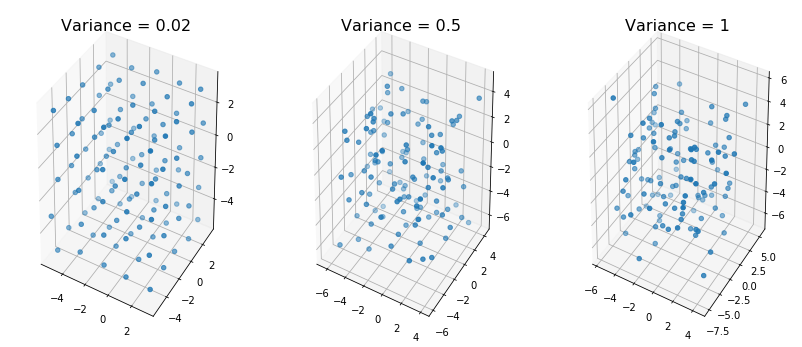

In [8]:
box, points = util.make_sc(5, 5, 5)
fig = plt.figure(figsize=(14, 6))
axes = []
plot_str = "1" + str(len(variances)) + "{}"
for i, v in enumerate(variances):
    axes.append(fig.add_subplot(plot_str.format(i+1), projection='3d'))
    axes[-1].scatter(point_arrays[i][:, 0], point_arrays[i][:, 1], point_arrays[i][:, 2])
    axes[-1].set_title("Variance = {}".format(v), fontsize=16);
plt.show()

If we recompute the Steinhardt OP for each of these data sets, we see that adding noise has the effect of smoothing the order parameter such that the peak we observed for the perfect crystal is no longer observable.

In [9]:
lds = []
Qls = []
for i, v in enumerate(variances):
    lds.append(freud.environment.LocalDescriptors(num_neighbors, l_max, r_max))
    lds[-1].compute(box, num_neighbors, point_arrays[i], mode='global', nlist=nls[i]);
    Qls.append(get_Ql(point_arrays[i], lds[-1], nls[i]))

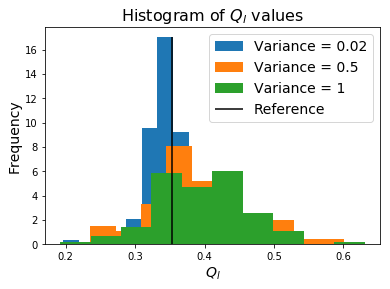

In [10]:
fig, ax = plt.subplots()
for i, Q in enumerate(Qls):
    lim_out = ax.hist(Q[:, L], label="Variance = {}".format(variances[i]), density=True)
    if i == 0:
        # Can choose any element, all are identical in the reference case
        ax.vlines(Ql[:, L][0], 0, np.max(lim_out[0]), label='Reference')
ax.set_title("Histogram of $Q_l$ values", fontsize=16)
ax.set_ylabel("Frequency", fontsize=14)
ax.set_xlabel("$Q_l$", fontsize=14)
ax.legend(fontsize=14);
plt.show()

This type of identification process is what the LocalDescriptors data outputs may be used for.
In the case of Steinhardt OPs, it provides a simple fingerprint for comparing thermalized systems to a known ideal structure to measure their similarity.

For reference, we can also check these values against the LocalQl class again

In [11]:
for i, pa in enumerate(point_arrays):
    ql = freud.order.LocalQl(box, r_max*2, L, 0)
    ql.compute(pa, nls[i])
    if np.allclose(ql.Ql, Qls[i][:, L]):
        print("Our manual Ql calculation matches the Steinhardt OP class!")

Our manual Ql calculation matches the Steinhardt OP class!
Our manual Ql calculation matches the Steinhardt OP class!
Our manual Ql calculation matches the Steinhardt OP class!
